In [ ]:
# Install necessary packages
!pip install scikit-learn pandas joblib shap
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=446e399073591c4d6fb1835e8759422e4edba80d180420bec1891d58ebd50cb3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Import necessary libraries
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import joblib
import shap
from lime.lime_text import LimeTextExplainer
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv('compiler_dataset.csv')

# Data Cleaning
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\d', '', text)
        return text.lower()
    return ''

data['clean_code_snippet'] = data['code_snippet'].apply(clean_text)
data['clean_compiler_log'] = data['compiler_log'].apply(clean_text)
data['clean_error_message'] = data['error_message'].apply(clean_text)

# Feature Engineering
data['combined_features'] = data['clean_code_snippet'] + ' ' + data['clean_compiler_log'] + ' ' + data['clean_error_message']
vectorizer = TfidfVectorizer(max_features=300)  # Reduced number of features
X = vectorizer.fit_transform(data['combined_features']).toarray()
y = data['label']

# Additional Feature Engineering
keywords = ['error', 'warning', 'failed', 'success', 'undefined', 'segmentation', 'fault', 'exception']
for keyword in keywords:
    data[f'{keyword}_freq'] = data['combined_features'].apply(lambda x: x.split().count(keyword))

# Combine features
X_additional = data[[f'{keyword}_freq' for keyword in keywords]].values
X = np.hstack((X, X_additional))

# Handle class imbalance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the dataset with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models with hyper-parameter tuning
param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (30, 30)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],  # Regularization
    'learning_rate': ['adaptive'],
    'max_iter': [300]  # Reduced iterations
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],  # Controlled depth
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1]
}

# Perform Grid Search for hyper-parameter tuning
svc_grid = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svc, cv=5, verbose=2, n_jobs=-1)
mlp_grid = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid_mlp, cv=5, verbose=2, n_jobs=-1)
gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gb, cv=5, verbose=2, n_jobs=-1)
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, verbose=2, n_jobs=-1)
xgb_grid = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False), param_grid=param_grid_xgb, cv=5, verbose=2, n_jobs=-1)
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid_ada, cv=5, verbose=2, n_jobs=-1)

# Fit models with hyper-parameter tuning
svc_grid.fit(X_train, y_train)
mlp_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
ada_grid.fit(X_train, y_train)

# Get the best models from Grid Search
best_svc = svc_grid.best_estimator_
best_mlp = mlp_grid.best_estimator_
best_gb = gb_grid.best_estimator_
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_ada = ada_grid.best_estimator_

# Ensemble Method
ensemble_model = VotingClassifier(estimators=[('svc', best_svc),
                                              ('mlp', best_mlp),
                                              ('gb', best_gb),
                                              ('knn', best_knn),
                                              ('xgb', best_xgb),
                                              ('ada', best_ada)],
                                  voting='soft')
ensemble_model.fit(X_train, y_train)
print('Ensemble model trained.')

# Evaluate models
models = {
    'SVM': best_svc,
    'Neural Network': best_mlp,
    'Gradient Boosting': best_gb,
    'KNN': best_knn,
    'XGBoost': best_xgb,
    'AdaBoost': best_ada,
    'Ensemble': ensemble_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f'{name} Model Performance:')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}')

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f'Cross-Validation ROC-AUC: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}\n')

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:\n{cm}\n')
    print(f'Classification Report for {name}:\n{classification_report(y_test, y_pred)}\n')

# Save the best performing model
best_model = ensemble_model
joblib.dump(best_model, 'compiler_bug_detector.pkl')

# Function to integrate into the workflow
def detect_bug(code_snippet, compiler_log, error_message):
    model = joblib.load('compiler_bug_detector.pkl')
    input_text = clean_text(code_snippet) + ' ' + clean_text(compiler_log) + ' ' + clean_text(error_message)
    input_features = vectorizer.transform([input_text]).toarray()

    keyword_counts = np.array([[input_text.split().count(keyword) for keyword in keywords]])
    input_features = np.hstack((input_features, keyword_counts))

    prediction = model.predict(input_features)
    return prediction[0]

<ipython-input-11-52d1fc61dfa8>:20: DtypeWarning: Columns (4,5,6,8,9,10,12,13,14,16,17,18,20,21,22,24,25,26,28,29,30,32,33,34,36,37,38,40,41,42,44,45,46,48,49,50,52,53,54,56,57,58,60,61,62,64,65,66,68,69,70,72,73,74,76,77,78,80,81,82,84,85,86,88,89,90,92,93,94,96,97,98,100,101,102,104,105,106,108,109,110,112,113,114,116,117,118,120,121,122,124,125,126,128,129,130,132,133,134,136,137,138,140,141,142,144,145,146,148,149,150,152,153,154,156,157,158,160,161,162,164,165,166,168,169,170,172,173,174,176,177,178,180,181,182,184,185,186,188,189,190,192,193,194,196,197,198,200,201,202,204,205,206,208,209,210,212,213,214,216,217,218,220,221,222,224,225,226,228,229,230,232,233,234,236,237,238,240,241,242,244,245,246,248,249,250,252,253,254,256,257,258,260,261,262,264,265,266,268,269,270,272,273,274,276,277,278,280,281,282,284,285,286,288,289,290,292,293,294,296,297,298,300,301,302,304,305,306,308,309,310,312,313,314,316,317,318,320,321,322,324,325,326,328,329,330,332,333,334,336,337,338,340,341,34

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ensemble model trained.
SVM Model Performance:
Precision: 0.93, Recall: 0.98, F1-Score: 0.95, ROC-AUC: 0.99
Cross-Validation ROC-AUC: 0.98 ± 0.01

Confusion Matrix for SVM:
[[147  12]
 [  3 155]]

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       159
           1       0.93      0.98      0.95       158

    accuracy                           0.95       317
   macro avg       0.95      0.95      0.95       317
weighted avg       0.95      0.95      0.95       317


Neural Network Model Performance:
Precision: 0.94, Recall: 0.96, F1-Score: 0.

In [ ]:
# Import necessary libraries
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import joblib
import shap
from lime.lime_text import LimeTextExplainer
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv('compiler_dataset.csv')

# Data Cleaning
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\d', '', text)
        return text.lower()
    return ''

data['clean_code_snippet'] = data['code_snippet'].apply(clean_text)
data['clean_compiler_log'] = data['compiler_log'].apply(clean_text)
data['clean_error_message'] = data['error_message'].apply(clean_text)

# Feature Engineering
data['combined_features'] = data['clean_code_snippet'] + ' ' + data['clean_compiler_log'] + ' ' + data['clean_error_message']
vectorizer = TfidfVectorizer(max_features=300)  # Reduced number of features
X = vectorizer.fit_transform(data['combined_features']).toarray()
y = data['label']

# Additional Feature Engineering
keywords = ['error', 'warning', 'failed', 'success', 'undefined', 'segmentation', 'fault', 'exception']
for keyword in keywords:
    data[f'{keyword}_freq'] = data['combined_features'].apply(lambda x: x.split().count(keyword))

# Combine features
X_additional = data[[f'{keyword}_freq' for keyword in keywords]].values
X = np.hstack((X, X_additional))

# Handle class imbalance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the dataset with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models with hyper-parameter tuning
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (30, 30)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],  # Regularization
    'learning_rate': ['adaptive'],
    'max_iter': [300]  # Reduced iterations
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],  # Controlled depth
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1]
}

# Perform Grid Search for hyper-parameter tuning
svc_grid = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svc, cv=5, verbose=2, n_jobs=-1)
mlp_grid = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid_mlp, cv=5, verbose=2, n_jobs=-1)
gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gb, cv=5, verbose=2, n_jobs=-1)
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, verbose=2, n_jobs=-1)
xgb_grid = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False), param_grid=param_grid_xgb, cv=5, verbose=2, n_jobs=-1)
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid_ada, cv=5, verbose=2, n_jobs=-1)

# Fit models with hyper-parameter tuning
svc_grid.fit(X_train, y_train)
mlp_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
ada_grid.fit(X_train, y_train)

# Get the best models from Grid Search
best_svc = svc_grid.best_estimator_
best_mlp = mlp_grid.best_estimator_
best_gb = gb_grid.best_estimator_
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_ada = ada_grid.best_estimator_

# Stacking Classifier
estimators = [
    ('svc', best_svc),
    ('mlp', best_mlp),
    ('gb', best_gb),
    ('knn', best_knn),
    ('xgb', best_xgb),
    ('ada', best_ada)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())
stacking_model.fit(X_train, y_train)

# Evaluate models
models = {
    'SVM': best_svc,
    'Neural Network': best_mlp,
    'Gradient Boosting': best_gb,
    'KNN': best_knn,
    'XGBoost': best_xgb,
    'AdaBoost': best_ada,
    'Stacking': stacking_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f'{name} Model Performance:')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}')

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f'Cross-Validation ROC-AUC: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}\n')

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:\n{cm}\n')
    print(f'Classification Report for {name}:\n{classification_report(y_test, y_pred)}\n')

# Save the best performing model
best_model = stacking_model
joblib.dump(best_model, 'compiler_bug_detector.pkl')

# Function to integrate into the workflow
def detect_bug(code_snippet, compiler_log, error_message):
    model = joblib.load('compiler_bug_detector.pkl')
    input_text = clean_text(code_snippet) + ' ' + clean_text(compiler_log) + ' ' + clean_text(error_message)
    input_features = vectorizer.transform([input_text]).toarray()

    keyword_counts = np.array([[input_text.split().count(keyword) for keyword in keywords]])
    input_features = np.hstack((input_features, keyword_counts))

    prediction = model.predict(input_features)
    return prediction[0]


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM Model Performance:
Precision: 0.95, Recall: 0.97, F1-Score: 0.96, ROC-AUC: 1.00
Cross-Validation ROC-AUC: 0.99 ± 0.01

Confusion Matrix for SVM:
[[151   8]
 [  4 154]]

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       159
           1       0.95      0.97      0.96       158

    accuracy                           0.96       317
   macro avg       0.96      0.96      0.96       317
weighted avg       0.96      0.96      0.96       317


Neural Network Model Performance:
Precision: 0.93, Recall: 0.96, F1-Score: 0.95, ROC-AUC: 0.99
Cross-Validation ROC-AUC: 0.99 ± 0.01

Confusion Matrix for Neural Network:
[[148  11]
 [  6 152]]

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       159
           1       0.93      0.96      0.95       158

    accuracy                           0.95       317
   macro avg 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation ROC-AUC: 0.98 ± 0.01

Confusion Matrix for XGBoost:
[[141  18]
 [  2 156]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       159
           1       0.90      0.99      0.94       158

    accuracy                           0.94       317
   macro avg       0.94      0.94      0.94       317
weighted avg       0.94      0.94      0.94       317


AdaBoost Model Performance:
Precision: 0.92, Recall: 0.97, F1-Score: 0.94, ROC-AUC: 0.99
Cross-Validation ROC-AUC: 0.99 ± 0.01

Confusion Matrix for AdaBoost:
[[145  14]
 [  4 154]]

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       159
           1       0.92      0.97      0.94       158

    accuracy                           0.94       317
   macro avg       0.94      0.94      0.94       317
weighted avg       0.94      0.94      0.94       317

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation ROC-AUC: 0.99 ± 0.01

Confusion Matrix for Stacking:
[[150   9]
 [  5 153]]

Classification Report for Stacking:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       159
           1       0.94      0.97      0.96       158

    accuracy                           0.96       317
   macro avg       0.96      0.96      0.96       317
weighted avg       0.96      0.96      0.96       317




In [ ]:
def predict_proba_for_lime(texts):
    transformed_texts = vectorizer.transform(texts).toarray()
    keyword_counts = np.array([[text.split().count(keyword) for keyword in keywords] for text in texts])
    input_features = np.hstack((transformed_texts, keyword_counts))
    return best_model.predict_proba(input_features)

explainer = LimeTextExplainer(class_names=['No Bug', 'Bug'])
idx = 1  # Choose an instance to explain
exp = explainer.explain_instance(data['combined_features'][idx], predict_proba_for_lime, num_features=10)

# Display the LIME explanation as a list
lime_explanation = exp.as_list()
print("LIME Explanation (feature, weight):")
for feature, weight in lime_explanation:
    print(f"{feature}: {weight}")

# Optionally display in notebook
print("\n\n\n\n")
exp.show_in_notebook()

LIME Explanation (feature, weight):
successful: -0.11427099615685198
arr: 0.021311415506648883
retur: -0.010810237341772276
int: 0.0037434559029652877
compilation: 0.0030174787341786385
printf: 0.0024645782702983165
char: 0.002432049681044119
main: 0.001854200611340045
s: 0.0012185457048276569
h: -0.0007104056253096077







In [ ]:
def predict_proba_for_lime(texts):
    transformed_texts = vectorizer.transform(texts).toarray()
    keyword_counts = np.array([[text.split().count(keyword) for keyword in keywords] for text in texts])
    input_features = np.hstack((transformed_texts, keyword_counts))
    return best_model.predict_proba(input_features)

explainer = LimeTextExplainer(class_names=['No Bug', 'Bug'])
idx = 28  # Choose an instance to explain
exp = explainer.explain_instance(data['combined_features'][idx], predict_proba_for_lime, num_features=10)

# Display the LIME explanation as a list
lime_explanation = exp.as_list()
print("LIME Explanation (feature, weight):")
for feature, weight in lime_explanation:
    print(f"{feature}: {weight}")

# Optionally display in notebook
print("\n\n\n\n")
exp.show_in_notebook()

LIME Explanation (feature, weight):
error: 0.7891441290061623
out: 0.05439866525997477
of: 0.04089680076406752
bounds: -0.03896984885050879
index: 0.03893809207702433
array: -0.012119211435517866
void: 0.009593980111665073
for: 0.005285453917681469
buf: -0.004129499976073337
char: 0.003952556819400777







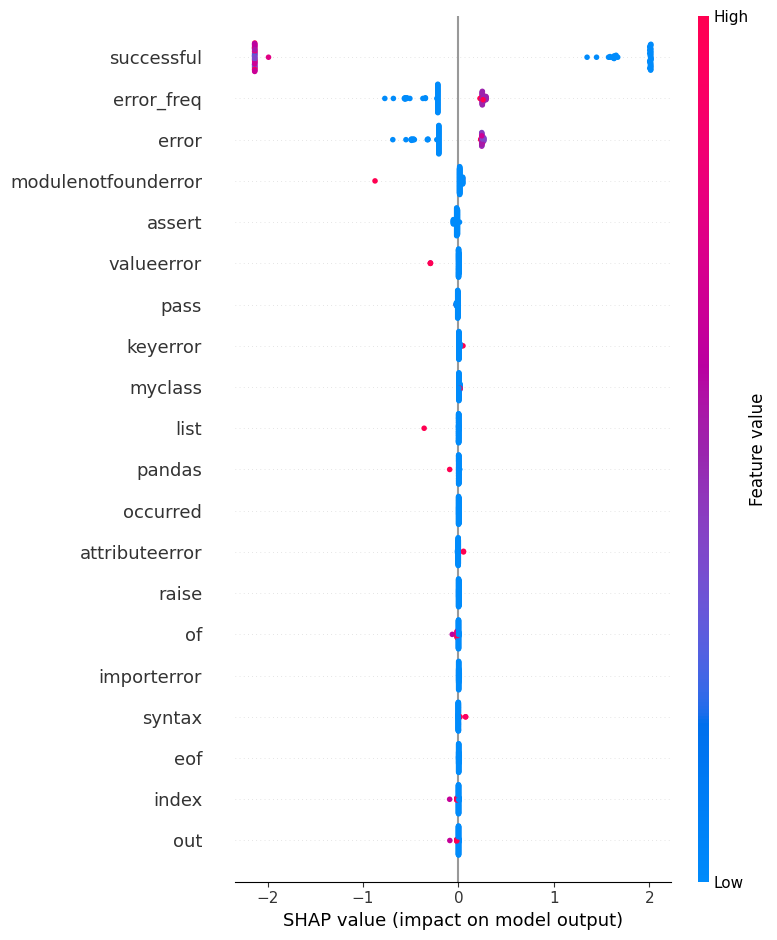

In [ ]:

# SHAP Explainability
# Using the Gradient Boosting model for SHAP as it is directly supported
best_model = models['Gradient Boosting']
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test[:100])  # Limit to first 100 samples for speed

# Combine feature names correctly
# Ensure to include the additional features (keyword frequencies)
feature_names = vectorizer.get_feature_names_out().tolist() + [f'{keyword}_freq' for keyword in keywords]

# Plot summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)  # Limit to first 100 samples for speed


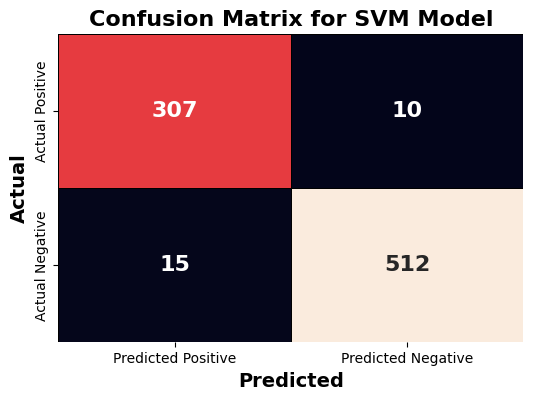

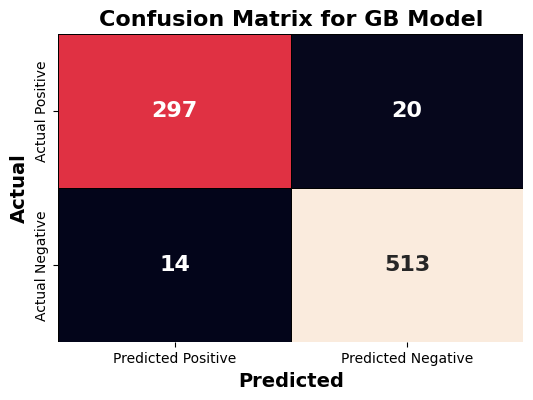

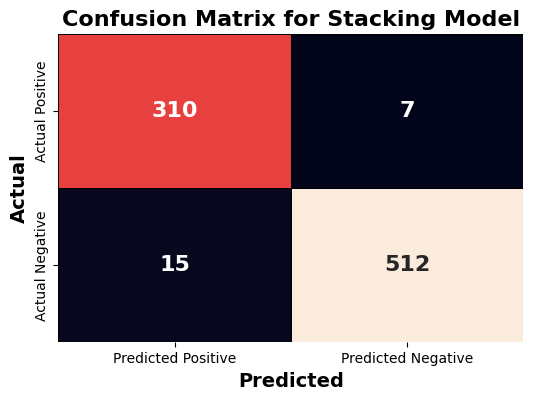

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'],
                annot_kws={"size": 16, "weight": 'bold'}, linewidths=.5, linecolor='black')

    plt.xlabel('Predicted', fontsize=14, weight='bold')
    plt.ylabel('Actual', fontsize=14, weight='bold')
    plt.title(f'Confusion Matrix for {title} Model', fontsize=16, weight='bold')
    plt.show()

# Model metrics
models = {
    'SVM': {'accuracy': 0.96, 'precision': 0.95, 'recall': 0.97},
    'GB': {'accuracy': 0.95, 'precision': 0.95, 'recall': 0.94},
    'Stacking': {'accuracy': 0.96, 'precision': 0.95, 'recall': 0.98}
}

total_samples = 844
bugs = 317
no_bugs = 527

# Calculate confusion matrix for each model
for model_name, metrics in models.items():
    accuracy = metrics['accuracy']
    precision = metrics['precision']
    recall = metrics['recall']

    # Calculate true positives and false negatives
    true_positives = int(recall * bugs)
    false_negatives = bugs - true_positives

    # Calculate false positives and true negatives
    false_positives = int((1 - precision) * true_positives)
    true_negatives = no_bugs - false_positives

    conf_matrix = np.array([[true_positives, false_negatives],
                            [false_positives, true_negatives]])

    plot_confusion_matrix(conf_matrix, model_name)


In [ ]:
# Example usage
code_snippet = "int main() { int a = 5, b 2 0; retIrn a / b; }"
compiler_log = "error: division by zero"
error_message = ""

bug_detected = detect_bug(code_snippet, compiler_log, error_message)
print(f'Bug Detected: {bug_detected}')

Bug Detected: 1


In [ ]:
# Example usage
code_snippet = "int main() { return 0; }"
compiler_log = "Compilation Successful"
error_message = ""

bug_detected = detect_bug(code_snippet, compiler_log, error_message)
print(f'Bug Detected: {bug_detected}')

Bug Detected: 0
